# Imports

In [1]:
import pandas as pd
import torch
from google.colab import drive
import os
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import zipfile
import io
import cv2
import numpy as np

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


# Allow for Drive Access

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Preprocessing (may have to change path to run locally)

In [3]:
pth = '/content/drive/MyDrive/18.065 Final Project/Videos Images' # data path where images are stored

for subdir, dirs, files in os.walk(pth):
    for file in files:
        print(os.path.join(subdir, file))

/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/D12EFCD1-B4A1-4572-90FA-71694C070CA7.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/2ABE5B7C-EA75-44AB-9E63-6F751A7AAA3A.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/BB761EFB-59A1-4D78-B575-D06C1D234D70.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/96E31279-96D4-49F9-8633-B46C0D432AC1.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon First Film/9AED2DFC-8A4D-4F18-BC4D-0E9A4EA1BCE7.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/E2C446AF-19A5-4C96-8785-CC52B726F30B.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/46610F1A-457C-4A31-A791-BC53CB16182C.zip
/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film/10CFFEFC-48D7-44C0-9403-F36571FD7B62.zip
/content/drive/MyDrive/18.065 

# Visualize Thermal time series

In [4]:
thermal_df = '/content/drive/MyDrive/18.065 Final Project/CSV Files /thermal_data_truss.csv'
thermal_df = pd.read_csv(thermal_df)
print(len(thermal_df))
thermal_df.head()

9665


,Time_s,ROI1_Temp,ROI2_Temp,Max_Temp,Min_Temp
0,0.000000,119.656863,72.570806,265.0,15.0
1,0.040391,119.656863,72.570806,265.0,15.0
2,0.080782,119.656863,72.570806,265.0,15.0
3,0.121173,119.656863,72.570806,265.0,15.0
4,0.161564,119.656863,72.570806,265.0,15.0


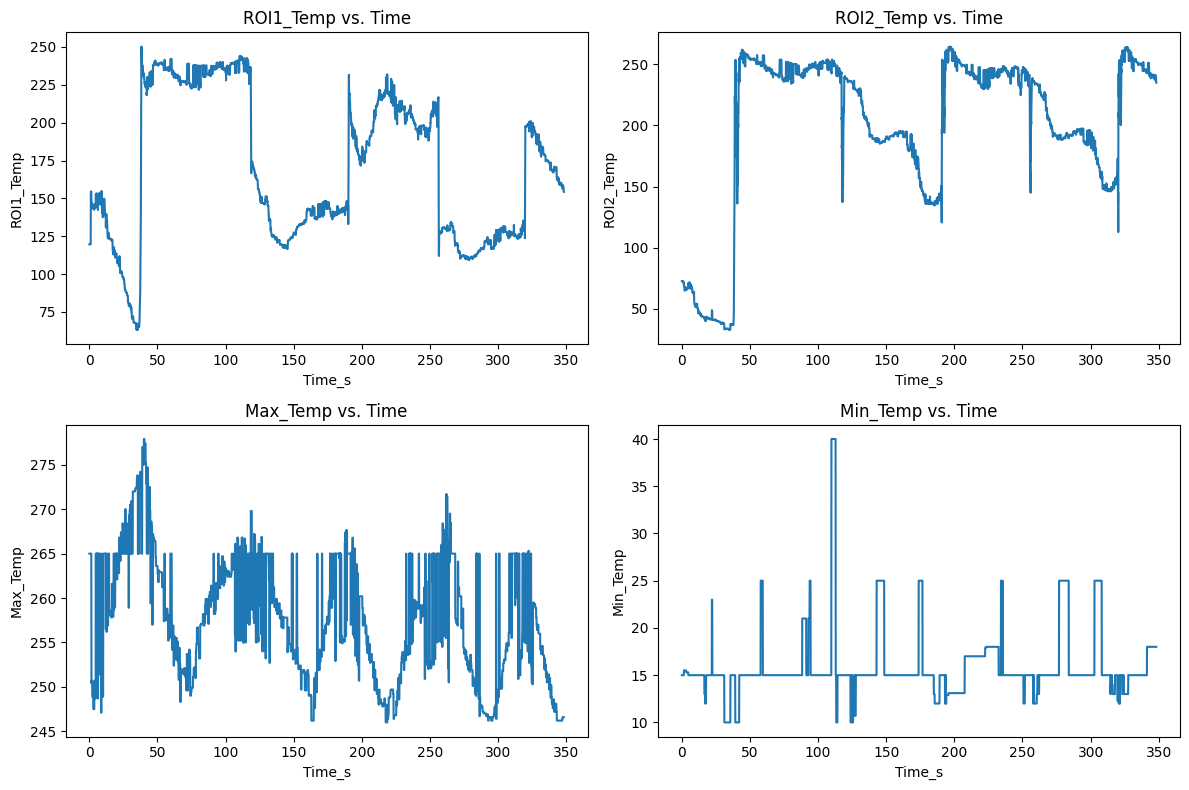

In [5]:
features_to_plot = [col for col in thermal_df.columns if col != 'Time_s']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through the features and plot them on the subplots
for i, feature in enumerate(features_to_plot[:4]): # Plot only the first four features
    row = i // 2
    col = i % 2
    axes[row, col].plot(thermal_df['Time_s'], thermal_df[feature])
    axes[row, col].set_xlabel('Time_s')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature} vs. Time')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Slumping data

In [6]:
slumping_df = pd.read_csv('/content/drive/MyDrive/18.065 Final Project/CSV Files /slumping_data.csv')
slumping_df.head()

,Time_s,ROI1_Temp,ROI2_Temp,Max_Temp,Min_Temp
0,0.000000,148.333333,150.882353,265.0,15.0
1,0.040028,148.333333,150.882353,265.0,15.0
2,0.080055,148.333333,150.882353,265.0,15.0
3,0.120083,148.333333,150.882353,265.0,15.0
4,0.160111,148.333333,150.882353,265.0,15.0


In [5]:
features_to_plot = [col for col in slumping_df.columns if col != 'Time_s']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through the features and plot them on the subplots
for i, feature in enumerate(features_to_plot[:4]): # Plot only the first four features
    row = i // 2
    col = i % 2
    axes[row, col].plot(slumping_df['Time_s'], slumping_df[feature])
    axes[row, col].set_xlabel('Time_s')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature} vs. Time')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

NameError: name 'slumping_df' is not defined

# Define function for reading in mp4 videos from zip

In [6]:
def open_mp4_video(mp4_path):
  cap = cv2.VideoCapture(mp4_path)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(frame)
  cap.release()
  return frames

In [7]:
video_pths = ['/content/drive/MyDrive/18.065 Final Project/Videos Images/3-4 FlexCon 2nd Film',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/3-6 FlexCon 1st',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/Slumping',
              '/content/drive/MyDrive/18.065 Final Project/Videos Images/Truss']

all_videos = []
for pth in video_pths:
  frames = []
  for subdir, dirs, files in os.walk(pth):
      for file in files:
          if file.endswith('.mp4'):
              frames.append(open_mp4_video(os.path.join(subdir, file)))
  flattened_frames = [frame for sublist in frames for frame in sublist]
  all_videos.append(flattened_frames)

In [8]:
print(len(all_videos))
print(len(all_videos[0]))
assert (all_videos[i][j].shape == (320, 240, 3) for i in range(len(all_videos)) for j in range(len(all_videos[i])))

4
8136


In [9]:
temp_pths = ['/content/drive/MyDrive/18.065 Final Project/CSV Files /FlexCon_34_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /FlexCon_36_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /slumping_data.csv',
             '/content/drive/MyDrive/18.065 Final Project/CSV Files /thermal_data_truss.csv']

all_temps = []
for pth in temp_pths:
  temp = pd.read_csv(pth).drop(columns=['Time_s', 'ROI2_Temp', 'Min_Temp', 'Max_Temp']).values
  all_temps.append(temp)
print(len(all_temps))
print(len(all_temps[0]))

4
8136


In [10]:
# split into train/val datasets
videos_train = []
targets_train = []
videos_val = []
targets_val = []

for video, temp in zip(all_videos, all_temps):
  min_len = min(len(video), len(temp))
  video = video[:min_len]
  temp = temp[:min_len]
  sublists_video = np.array_split(video, 50)
  sublists_temp = np.array_split(temp, 50)
  for i, (video, temp) in enumerate(zip(sublists_video, sublists_temp)):
    if i < 30:
      videos_train.append(video[::5])
      targets_train.append(temp[::5])
    else:
      videos_val.append(video[::5])
      targets_val.append(temp[::5])

120
120
80
80


# Define model architecture

In [11]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=512):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  # (B,32,320,240)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                       # (B,32,160,120)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),           # (B,64,160,120)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                       # (B,64, 80, 60)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),          # (B,128,80,60)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                       # (B,128,40,30)
            nn.AdaptiveAvgPool2d((1,1))                            # (B,128,1,1)
        )
        self.fc = nn.Linear(128, feat_dim)

    def forward(self, x):
        # x: (B, C, 320, 240)
        x = self.conv(x)               # (B,128,1,1)
        x = x.view(x.size(0), -1)      # (B,128)
        return self.fc(x)              # (B,feat_dim)


class CNN_RNN_Predictor(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        feat_dim:     int = 512,
        hidden_dim:   int = 256,
        output_dim:   int = 1,
        num_layers:   int = 1,
        nonlinearity: str = 'relu'  # 'tanh' or 'relu'
    ):
        super().__init__()
        self.encoder = CNNEncoder(in_channels, feat_dim)

        self.rnn = nn.RNN(
            input_size=feat_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True
        )

        self.act  = nn.ReLU()
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, video):
        # video: (B, T, C, H, W)
        B, T, C, H, W = video.shape

        x = video.view(B*T, C, H, W).permute(0, 3, 1, 2).contiguous()
        feats = self.encoder(x)           # (B*T, feat_dim)
        feats = feats.view(B, T, -1)      # (B, T, feat_dim)

        # temporal with RNN
        rnn_out, _ = self.rnn(feats)      # (B, T, hidden_dim)

        # non-linear + head
        h   = self.act(rnn_out)           # (B, T, hidden_dim)
        out = self.head(h)                # (B, T, output_dim)
        return out

In [12]:
torch.cuda.empty_cache()

In [13]:
model = CNN_RNN_Predictor(output_dim = 1)

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class VideoWindowDataset(Dataset):
    def __init__(self, videos, targets, window_size, stride, summary_fn):
        """
        videos: list of (T_i, C, H, W) arrays
        targets: list of (T_i, D) arrays
        window_size, stride: ints
        summary_fn: fn that maps a (window_size, D) array -> scalar
        """
        self.windows = []
        for vid, tgt in zip(videos, targets):
            T = vid.shape[0]
            # slide a window of length window_size
            for start in range(0, T - window_size + 1, stride):
                end = start + window_size
                v_win = vid[start:end]          # (window_size, C, H, W)
                t_win = tgt[start:end]          # (window_size, D)
                s_val = summary_fn(t_win)       # scalar
                self.windows.append((v_win, t_win, s_val))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        v, t, s = self.windows[idx]
        return torch.from_numpy(v).float(), torch.from_numpy(t).float(), s

# 1) Build the dataset
def mean_summary(t_win):
    return float(t_win.mean())  # or .mean(axis=0)[0], etc.

ds = VideoWindowDataset(
    videos=videos_train,
    targets=targets_train,
    window_size=20,
    stride=5,
    summary_fn=mean_summary
)

# 2) Compute histogram over all s_vals
all_s = np.array([s for _,_,s in ds.windows])
bins = np.linspace(all_s.min(), all_s.max(), 50)
bin_idx = np.digitize(all_s, bins)
counts = np.bincount(bin_idx, minlength=len(bins)+1)

# 3) Compute sample weights ∝ 1 / count[bin]
weights = 1.0 / counts[bin_idx]
weights = torch.tensor(weights, dtype=torch.double)

# 4) Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

# 5) DataLoader
loader = DataLoader(
    ds,
    batch_size=8,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)


# Set up Training loop

In [15]:
class VideoDataset(Dataset):
    def __init__(self, videos, targets):
        """
        videos: list or array of shape (N, T, C, H, W)
        targets: list or array of shape (N, T, output_dim)
        """
        self.videos = videos
        self.targets = targets

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        # Return one sample: video tensor and corresponding target tensor
        video = torch.tensor(self.videos[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        # get max sequence length from your training data
        max_seq_len = max(len(v) for v in videos_train)

        # Pad the video sequence to the max sequence length
        video = F.pad(video, (0, 0, 0, 0, 0, 0, 0, max_seq_len - video.shape[0]))

        # Pad the target sequence to the max sequence length
        target = F.pad(target, (0, 0, 0, max_seq_len - target.shape[0]))

        return video, target

# Assume videos_train, targets_train, videos_val, targets_val are prepared numpy arrays or similar
val_dataset   = VideoDataset(videos_val, targets_val)


val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Updated training loop with per-sample loss weighting
criterion = nn.L1Loss(reduction='none')  # we'll compute per-element errors
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50
log_interval = 26

for epoch in range(1, num_epochs + 1):
    print(f'On epoch {epoch}')
    # --- Training ---
    model.train()
    running_loss = 0.0
    for batch_idx, (videos, targets, weights) in enumerate(loader, start=1):
        videos, targets, weights = videos.to(device), targets.to(device), weights.to(device)  # weights: (B,)

        optimizer.zero_grad()
        outputs = model(videos)  # (B, T, output_dim)

        # 1) raw per-element MSE: shape (B, T, output_dim)
        se = criterion(outputs, targets)

        # 2) collapse T & output_dim to compute per-sample MSE: shape (B,)
        mse_per_sample = se.view(se.size(0), -1).mean(dim=1)

        # 3) apply sample weights and normalize by sum of weights
        loss = (mse_per_sample * weights).sum() / weights.sum()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % log_interval == 0:
            print(f"[Epoch {epoch}][{batch_idx}/{len(loader)}] "
                  f"Train Weighted Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(loader)
    print(f"Epoch {epoch} Training Weighted Loss: {avg_train_loss:.4f}\n")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for videos, targets in val_loader:
            videos  = videos.to(device)
            targets = targets.to(device)
            outputs = model(videos)
            val_loss += criterion(outputs, targets).mean().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch} Validation Loss: {avg_val_loss:.4f}\n")

On epoch 1
[Epoch 1][26/53] Train Weighted Loss: 35.7723
[Epoch 1][52/53] Train Weighted Loss: 70.8022
Epoch 1 Training Weighted Loss: 67.9004

Epoch 1 Validation Loss: 43.2224

On epoch 2
[Epoch 2][26/53] Train Weighted Loss: 48.8865
[Epoch 2][52/53] Train Weighted Loss: 61.2758
Epoch 2 Training Weighted Loss: 62.1585

Epoch 2 Validation Loss: 52.7324

On epoch 3
[Epoch 3][26/53] Train Weighted Loss: 104.6737
[Epoch 3][52/53] Train Weighted Loss: 51.8302
Epoch 3 Training Weighted Loss: 55.2030

Epoch 3 Validation Loss: 26.9105

On epoch 4
[Epoch 4][26/53] Train Weighted Loss: 77.5047
[Epoch 4][52/53] Train Weighted Loss: 88.4632
Epoch 4 Training Weighted Loss: 53.7573

Epoch 4 Validation Loss: 56.1432

On epoch 5
[Epoch 5][26/53] Train Weighted Loss: 44.9254
[Epoch 5][52/53] Train Weighted Loss: 54.8074
Epoch 5 Training Weighted Loss: 56.6367

Epoch 5 Validation Loss: 23.9967

On epoch 6
[Epoch 6][26/53] Train Weighted Loss: 39.2787
[Epoch 6][52/53] Train Weighted Loss: 71.3503
Epoch 

# Some test evaluation

In [16]:
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for videos, targets, in val_loader:
        videos = videos.to(device)
        targets = targets.to(device)
        outputs = model(videos)
        all_targets.extend(targets.cpu().numpy().flatten())
        all_predictions.extend(outputs.cpu().numpy().flatten())

r2 = r2_score(all_targets, all_predictions)
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

print(f"R^2 on validation set: {r2:.4f}")
print(f"RMSE on validation set: {rmse:.4f}")

R^2 on validation set: 0.7545
RMSE on validation set: 38.6214


# Plot/Visualization for presentation

80


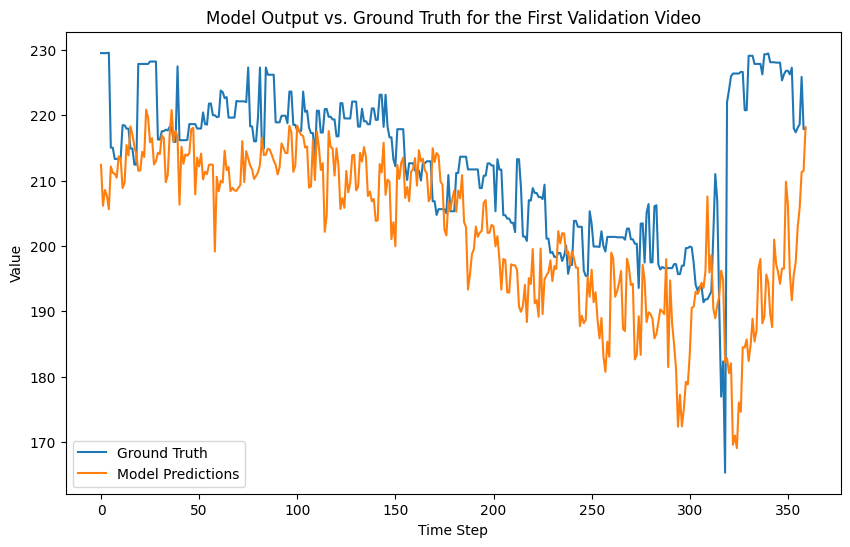

In [20]:
# prompt: plot the model outputs of the first video in the validation set with the ground truth values

# Assuming 'val_loader' and 'model' are defined as in your provided code.
# Also assuming 'device' is defined.

model.eval()
all_outputs = []
all_targets = []
print(len(val_loader))
for i, (videos, targets) in enumerate(val_loader):
    if i in range(30,40):  # Process sample video
      videos = videos.to(device)
      targets = targets.to(device)
      with torch.no_grad():
          outputs = model(videos)

      # Convert tensors to numpy arrays
      outputs = outputs.cpu().squeeze().numpy()
      targets = targets.cpu().squeeze().numpy()


      all_outputs += [outputs[i] for i in range(len(outputs))]
      all_targets += [targets[i] for i in range(len(targets))]


all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
mask = (all_outputs != 0.0) & (all_targets != 0.0)
filtered_all_predictions = all_outputs[mask]
filtered_all_targets_r2 = all_targets[mask]

plt.figure(figsize=(10, 6))
plt.plot(filtered_all_targets_r2, label='Ground Truth')
plt.plot(filtered_all_predictions, label='Model Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Model Output vs. Ground Truth for Sample Validation Video')
plt.legend()
plt.show()


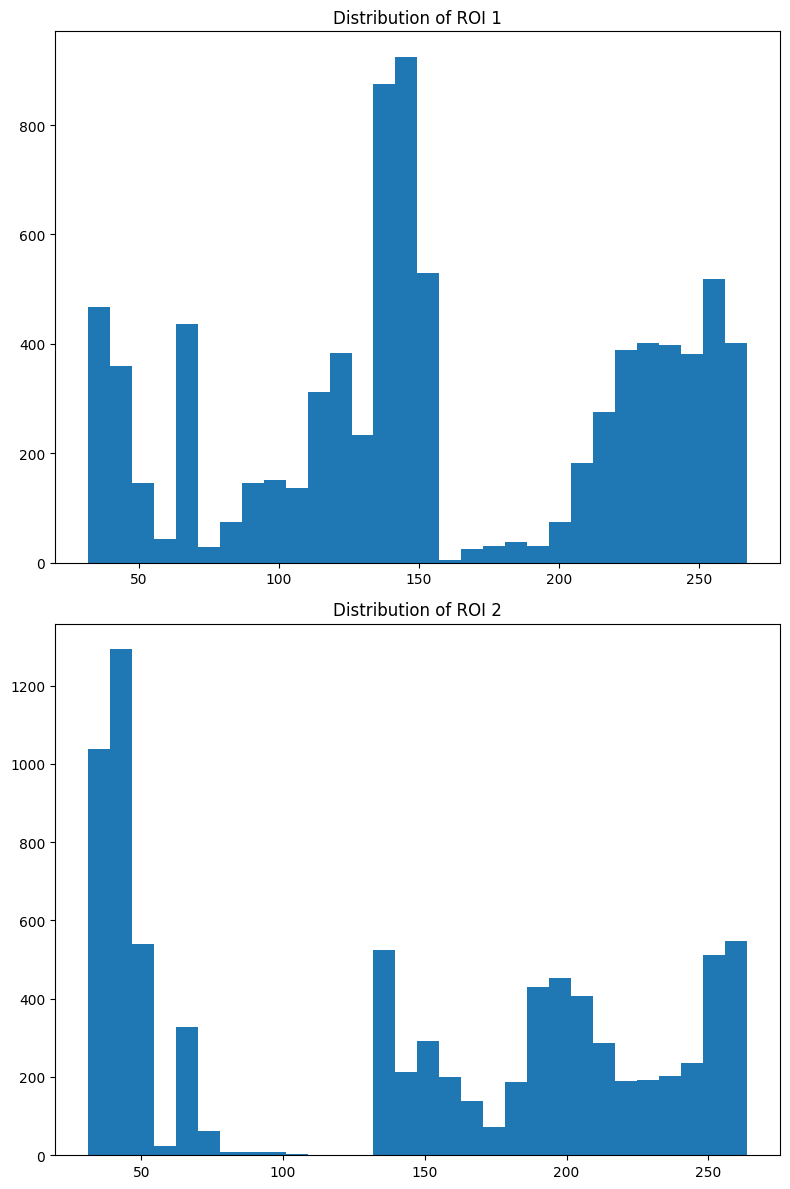

In [37]:
# prompt: plot the distribution of the targets in the train loader. there should be 4 separate plots for each feature

import matplotlib.pyplot as plt

# Assuming 'loader' is your DataLoader object

# Collect target values for each feature
targets_feature1 = []
targets_feature2 = []
targets_feature3 = []
targets_feature4 = []

for _, targets, _ in loader:
    targets_feature1.extend(targets[:, :, 0].flatten().numpy())
    targets_feature2.extend(targets[:, :, 1].flatten().numpy())
    targets_feature3.extend(targets[:, :, 2].flatten().numpy())
    targets_feature4.extend(targets[:, :, 3].flatten().numpy())

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8,12))

# Plot distributions
axes[0].hist(targets_feature1, bins=30)
axes[0].set_title("Distribution of ROI 1")

axes[1].hist(targets_feature2, bins=30)
axes[1].set_title("Distribution of ROI 2")

# axes[1, 0].hist(targets_feature3, bins=30)
# axes[1, 0].set_title("Distribution of Max Temp")

# axes[1, 1].hist(targets_feature4, bins=30)
# axes[1, 1].set_title("Distribution of Min Temp")

plt.tight_layout()
plt.show()
